In [1]:
import numpy as np
import bokeh.io
import bebi103.viz
import bebi103.stan
import pandas as pd
import altair as alt
bokeh.io.output_notebook()

Loading BokehJS ...

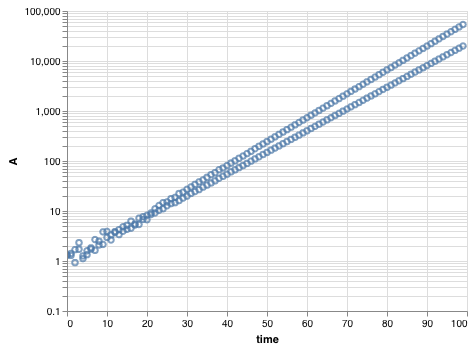

In [57]:
np.random.seed(666)
N = 100
idx = np.ones(2 * N)
idx[N:] = 2
idx = idx.astype(int)
time = np.arange(0, N);
A_0 = [10, 8]
r = [0.1, 0.11]
A = np.zeros(2 * N)
A[:N] = A_0[0] * np.exp(r[0] * time) + np.random.normal(0, 4, N_meas)
A[:N] /= A_0[0]
A[N:] = A_0[1] * np.exp(r[1] * time) + np.random.normal(0, 4, N_meas)
A[N:] /= A_0[1]
_time = np.zeros(2 * N)
_time[:N] = time
_time[N:] = time
data_dict = {'J':2, 'idx':idx, 'N':N*2, 'time': _time, 'A': A}
alt.Chart(pd.DataFrame.from_dict(data_dict)).mark_point().encode(x='time:Q', y=alt.Y('A:Q', scale={'type':'log'})).interactive()

In [ ]:
model = bebi103.stan.StanModel('growth_rate.stan')
samples = model.sampling(data_dict, iter=5000, control=dict(adapt_delta=0.95, max_treedepth=15))
p = bebi103.viz.corner(samples, vars=['r', 'r_1[1]', 'r_1[2]', 'sigma_1[1]', 'sigma_1[2]'], datashade=True)
bokeh.io.show(p)

Using cached StanModel.


In [ ]:
samples

In [4]:
# Generate a simple hierarchical gaussian model. 

In [46]:
np.random.seed(666)
mu = [80, 120] 
sigma =  [2, 4]
print(mu, sigma)
N_meas = 100
mu_1 = np.random.normal(mu[0], sigma[0], size=N_meas)
mu_2 = np.random.normal(mu[1], sigma[1], size=N_meas)
meas = np.zeros(2 * N_meas)
meas[:N_meas] = mu_1
meas[N_meas:] = mu_2
idx = np.ones(2 * N_meas)
idx[N_meas:] = 2

[80, 120] [2, 4]


In [51]:
model_code = """
data {
    int<lower=1> J;
    int<lower=1> N;
    int<lower=1, upper=J> idx[N];
    vector[N] meas;
}

parameters {
    real mu_1;
    real log_sigma_1;
    vector[J] mu_2_raw;
    vector[J] log_sigma_2_raw;
    real<lower=0> tau_mu;
    real<lower=0> tau_sigma;
}


transformed parameters {
    vector[J] mu_2 = mu_1 + mu_2_raw * tau_mu;
    vector[J] log_sigma_2 = log_sigma_1 + log_sigma_2_raw * tau_sigma;
    real sigma_1 = exp(log_sigma_1);
    vector[J] sigma_2 = exp(log_sigma_2);
}

model {
    mu_1 ~ normal(0, 100);
    mu_2_raw ~ normal(0, 1);
    log_sigma_1 ~ normal(0, 1);
    log_sigma_2_raw ~ normal(0, 1);
    tau_mu ~ normal(0, 1);
    tau_sigma ~ normal(0, 1);
    meas ~ normal(mu_2[idx], sigma_2[idx]);
}
"""
data_dict = {'J': 2,
            'N': 2 * N,
            'idx': idx.astype(int),
            'meas': meas}
test_model = bebi103.stan.StanModel(model_code=model_code)
samples = test_model.sampling(data_dict)

Using cached StanModel.


In [50]:
p = bebi103.viz.corner(samples, vars=['mu_1', 'mu_2[1]', 'mu_2[2]', 'sigma_2[1]', 'sigma_2[2]', 'sigma_1'],
                      datashade=True)
bokeh.io.show(p)

In [45]:
samples

Inference for Stan model: anon_model_e38b18179c9f838e60ace6507dce2d77.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_1                 1.44    0.02   1.02  -0.53   0.74   1.44   2.11   3.52   2739    1.0
log_sigma_1          0.66  8.7e-3   0.28  -0.04   0.59   0.69   0.77    1.2   1040   1.01
mu_2_raw[1]          8.36  9.7e-3   0.36   7.68   8.11   8.35    8.6   9.06   1372    1.0
mu_2_raw[2]          8.37  9.7e-3   0.36   7.69   8.12   8.36   8.61   9.06   1368    1.0
log_sigma_2_raw[1]  -0.11    0.02   0.79   -1.7  -0.62  -0.08    0.4   1.41   1430   1.01
log_sigma_2_raw[2]   0.22    0.02   0.78  -1.32  -0.29   0.22   0.72   1.81   1594    1.0
tau_mu               11.8    0.01   0.51  10.86  11.44  11.79  12.15  12.82   1385   1.01
tau_sigma            0.33    0.01   0.38 6.7e-3   0.07   0.19   0.45   1.38    976   1.01
m